In [1]:
import xarray as xr
import numpy as np
from his_utils import *
import his_preprocess
import pandas as pd
import os
import itertools
from concurrent.futures import ProcessPoolExecutor, as_completed

# input_data = xr.open_dataset('testdata/2021-06-21/ERA5_input.nc')
# input_data["2m_temperature"].isel(time=0).plot(figsize=(20, 10))
# list(input_data.data_vars)

In [19]:
import xarray as xr
import numpy as np
from jax import random, device_put
import jax.numpy as jnp


def add_tenpercent_perturbation(original: xr.Dataset, 
                                variables: list[str] = SURFACE_VARIABLE + PRESSURE_VARIABLE, 
                                scale: float = 1, 
                                perturb_timestep: list = [0, 1],
                                num_points: int = 23568048, 
                                wipe_out: bool = True):
    """
    original : xr.Dataset
        - (batch, time, lat, lon, [level]) 구조의 원본 데이터셋
    variables : list[str]
        - perturb를 적용할 변수 목록
        - 예) SURFACE_VARIABLE + PRESSURE_VARIABLE
    scale : float
        - gaussian noise의 scale factor (wipe_out=False 일 때 사용)
    perturb_timestep : list[int]
        - perturb를 적용할 time index 리스트 (기본값: [0,1])
    num_points : int
        - 전체 (표면+대기압) 격자의 10%에 해당하는 개수 (기본값: 23568048)
    wipe_out : bool
        - True이면 mean 값으로 치환, False이면 (scale * std * Normal(0,1))을 더함
    """
    # ---- 사전 세팅
    perturbed = original.copy()

    # lat/lon/level 크기
    lat_size = perturbed.sizes['lat']
    lon_size = perturbed.sizes['lon']
    level_size = perturbed.sizes['level'] if 'level' in perturbed.sizes else 1
    batch_size = perturbed.sizes['batch'] if 'batch' in perturbed.sizes else 1
    time_size = perturbed.sizes['time'] if 'time' in perturbed.sizes else 1

    # SURFACE_VARIABLE, PRESSURE_VARIABLE 식별
    # (여기서는 사용자가 직접 변수 리스트를 건네주므로, 실제 코드에서는
    #  surface인지, pressure인지 확인할 때 변수를 보고 판단해야 함)
    #  예: 5개 surface 변수, 6개 pressure 변수가 들어온다고 가정
    #  (만약 SURFACE_VARIABLE, PRESSURE_VARIABLE을 직접 분류할 필요가 있다면
    #   별도 로직을 추가)
    surface_vars = []
    pressure_vars = []
    for var in variables:
        if 'level' in perturbed[var].dims:
            pressure_vars.append(var)
        else:
            surface_vars.append(var)

    # (1) 변수별 격자 개수 계산
    # surface: lat_size * lon_size
    # pressure: level_size * lat_size * lon_size
    surf_grid = lat_size * lon_size
    press_grid = level_size * lat_size * lon_size

    # var_sizes: 각 변수(=DataArray)가 몇 개의 격자를 갖고 있는지
    var_sizes = []
    for var in surface_vars:
        var_sizes.append(surf_grid)
    for var in pressure_vars:
        var_sizes.append(press_grid)

    # jnp.array로 변환
    var_sizes_j = jnp.array(var_sizes)  # shape=(len(variables),)

    # var_offsets: 누적합 (0, var_sizes[0], var_sizes[0]+var_sizes[1], ...)
    var_offsets_j = jnp.cumsum(var_sizes_j)  # shape=(len(variables),)
    # searchsorted 할 때 편의를 위해 앞에 0을 하나 더 붙이거나,
    # side='right' 옵션을 잘 쓸 수도 있음.
    # 여기서는 side='right'을 쓰기 위해, offsets 앞에 0을 붙인 버전 사용
    var_offsets_j = jnp.concatenate([jnp.array([0]), var_offsets_j])  # shape=(len(variables)+1,)

    # (2) JAX로 데이터를 옮겨놓기
    original_data = {}
    for var in variables:
        original_data[var] = device_put(jnp.array(perturbed[var].values))

    # 표준편차/평균 데이터셋 로드 (사용자 환경에 맞게 경로 수정)
    with xr.open_dataset("/geodata2/S2S/DL/GC_input/stat/stats_stddev_by_level.nc") as std_ds, \
         xr.open_dataset("/geodata2/S2S/DL/GC_input/stat/stats_mean_by_level.nc") as mean_ds:

        std_data = {}
        mean_data = {}
        for var in variables:
            std_data[var] = device_put(jnp.array(std_ds[var].values))
            mean_data[var] = device_put(jnp.array(mean_ds[var].values))

        # 랜덤 시드
        key = random.PRNGKey(42)

        # (3) time loop
        for t_idx in perturb_timestep:
            if t_idx >= time_size:
                continue  # time 범위 넘어가면 skip

            # batch loop (예: batch=1이면 사실상 1번만)
            for b_idx in range(batch_size):
                # 3-1) num_points개를 전체( var_sizes 합 )에서 무작위로 뽑기
                total_points = var_offsets_j[-1]  # 모든 변수의 격자 총합
                key, subkey = random.split(key)
                rand_indices = random.choice(
                    subkey,
                    total_points,        # [0..total_points-1] 중에서
                    shape=(num_points,), # num_points 개를
                    replace=True        # 중복 없이 뽑음
                )

                # 3-2) 각 랜덤 인덱스가 어떤 변수인지 searchsorted로 판별
                # var_id: 0 ~ (len(variables)-1)
                # var_offsets_j: 누적합, shape=(len(variables)+1,)
                # 예: var_offsets_j = [0, surf_grid, 2*surf_grid, 2*surf_grid + press_grid, ...]
                # idx ∈ [var_offsets_j[v], var_offsets_j[v+1]) 이면 var_id = v
                var_id = jnp.searchsorted(var_offsets_j, rand_indices, side='right') - 1
                # local_index = rand_indices - var_offsets_j[var_id]
                local_index = rand_indices - var_offsets_j[var_id]

                # 3-3) 변수별로 모아서 perturb
                #      예: var_id == 0 인 것, var_id == 1 인 것 등등
                for i, var in enumerate(surface_vars + pressure_vars):
                    # 현재 var_id=i 인 random index들만 뽑는다
                    mask = (var_id == i)
                    # 그 중 실제 개수
                    count_i = jnp.sum(mask)
                    if count_i == 0:
                        continue

                    # 해당 var가 surface인지 pressure인지 구분
                    if var in surface_vars:
                        # local_index_surf: shape=(count_i,)
                        local_index_surf = local_index[mask]
                        # unravel: lat, lon
                        lat_idx, lon_idx = jnp.divmod(local_index_surf, lon_size)

                        # 가우시안 noise
                        key, subkey = random.split(key)
                        normal_dist = random.normal(subkey, shape=(count_i,))

                        if wipe_out:
                            # set mean
                            # mean_data[var]는 보통 (lat, lon) 또는 (level, lat, lon) 형식이지만
                            # 통계파일이 어떻게 만들어졌느냐에 따라 다름.
                            # 여기서는 'surface'에 level이 없다고 가정 → mean_data[var]는 2D or 1D
                            # 만약 mean_data[var]가 (lat, lon)이면, 해당 lat_idx, lon_idx 위치를 뽑아야 함.
                            # (아래에서는 "scalar or 2D 모두 가능"하다고 보고 단순히 scalar라 가정)
                            original_data[var] = original_data[var].at[
                                b_idx, t_idx, lat_idx, lon_idx
                            ].set(mean_data[var])  # 만약 mean_data[var]가 scalar라면 이렇게
                        else:
                            # add noise
                            original_data[var] = original_data[var].at[
                                b_idx, t_idx, lat_idx, lon_idx
                            ].add(scale * std_data[var] * normal_dist)

                    else:
                        # pressure var
                        local_index_press = local_index[mask]
                        # unravel: level, lat, lon
                        lvl_idx = local_index_press // (lat_size * lon_size)
                        latlon_local = local_index_press % (lat_size * lon_size)
                        lat_idx, lon_idx = jnp.divmod(latlon_local, lon_size)

                        # 가우시안 noise
                        key, subkey = random.split(key)
                        normal_dist = random.normal(subkey, shape=(count_i,))

                        if wipe_out:
                            # set mean
                            # mean_data[var]가 (level, lat, lon)인지, (level,) 인지 등
                            # 실제 통계파일 구조에 맞게 처리
                            original_data[var] = original_data[var].at[
                                b_idx, t_idx, lvl_idx, lat_idx, lon_idx
                            ].set(mean_data[var][lvl_idx])
                        else:
                            original_data[var] = original_data[var].at[
                                b_idx, t_idx, lvl_idx, lat_idx, lon_idx
                            ].add(scale * std_data[var][lvl_idx] * normal_dist)

        # (4) perturb된 결과를 np.array로 되돌려서 xarray에 붙여넣기
        for var in variables:
            perturbed[var].values = np.array(original_data[var])

        # 혹시 'perturbation' 변수가 있었다면 제거
        if 'perturbation' in perturbed.data_vars:
            perturbed = perturbed.drop_vars('perturbation')

    return perturbed


In [20]:
data = xr.open_dataset(f'testdata/2021-06-21/ERA5_input.nc')

In [21]:
new_data = add_tenpercent_perturbation(data)

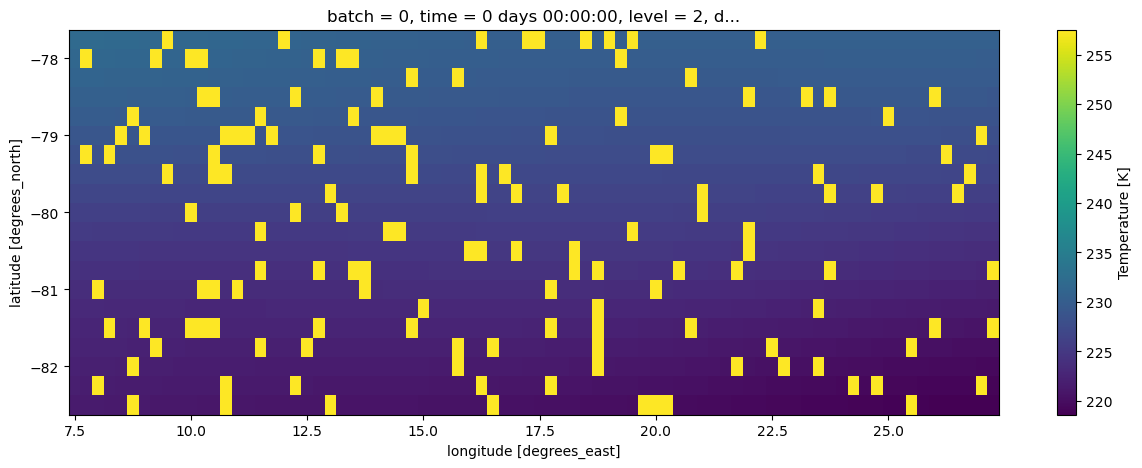

In [30]:
new_data["temperature"].isel(time=0, level=1, lat=slice(30,50), lon=slice(30,110)).plot(figsize=(15, 5))

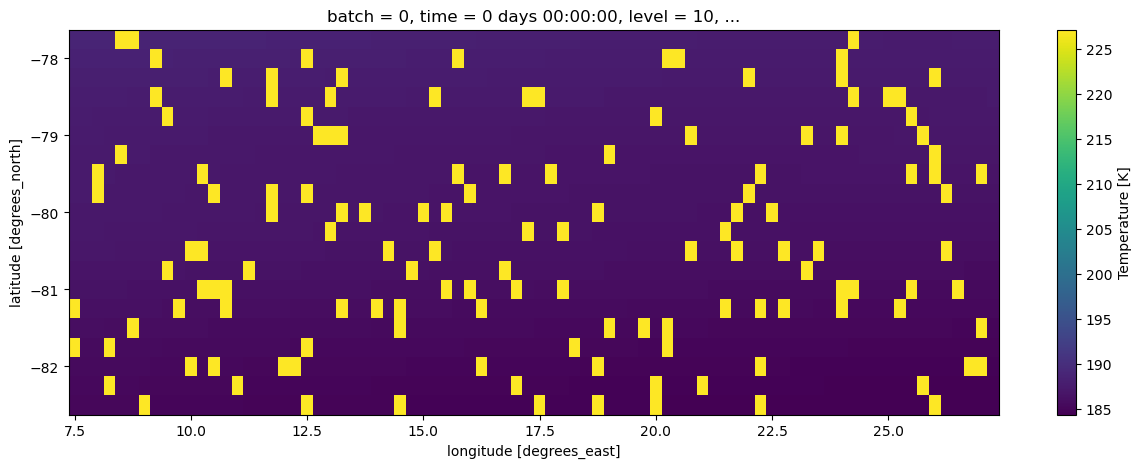

In [31]:
new_data["temperature"].isel(time=0, level=5, lat=slice(30,50), lon=slice(30,110)).plot(figsize=(15, 5))

# Scratch Codes

In [ ]:

# 5x5 numpy 배열 생성
data = np.arange(9).reshape(3,3)

# xarray DataArray 생성
da = xr.DataArray(
    data,
    dims=("latitude", "longitude"),  # 차원 이름 지정
    coords={
        "latitude": np.linspace(35, 39, 3),  # y 좌표
        "longitude": np.linspace(125, 129, 3) # x 좌표
    },
    name="example_data"  # DataArray의 이름
)

# 5x5 numpy 배열 생성
data = np.random.uniform(low=0, high=10, size=(3, 3))
data = np.round(data, decimals=0)

# xarray DataArray 생성
da2 = xr.DataArray(
    data,
    dims=("latitude", "longitude"),  # 차원 이름을 위도와 경도로 지정
    coords={
        "latitude": np.linspace(35, 39, 3),   # 위도 좌표 (35도에서 39도)
        "longitude": np.linspace(125, 129, 3) # 경도 좌표 (125도에서 129도)
    },
    name="temperature"  # DataArray의 이름을 temperature로 지정
)

data = np.random.uniform(low=0, high=10, size=(3, 3))
data = np.round(data, decimals=0)

# xarray DataArray 생성
da3 = xr.DataArray(
    data,
    dims=("latitude", "longitude"),  # 차원 이름을 위도와 경도로 지정
    coords={
        "latitude": np.linspace(35, 39, 3),   # 위도 좌표 (35도에서 39도)
        "longitude": np.linspace(125, 129, 3) # 경도 좌표 (125도에서 129도)
    },
    name="temperature"  # DataArray의 이름을 temperature로 지정
)

print(da)
print(da2)
print(da3)

da + 0.1 * (da2 * da3)

In [ ]:
dataset_21 = xr.open_dataset('testdata/2021-06-21/ERA5_4var_1std.nc')
dataset_26 = xr.open_dataset('testdata/2021-06-26/ERA5_4var_1std.nc')
dataset_21

In [ ]:
dataset_26